# W6.3: Model Quantization for Training and Inference

In this notebook, we'll explore model quantization techniques for both training and inference. The distinction between training and inference quantization is that in training, we quantize the model weights and activations, while in inference, we quantize the model weights. Quantization reduces the precision of model weights, activations, and gradients, enabling:

- Smaller memory footprints
- Faster inference and training
- Ability to fit large models on available hardware

We'll cover:
1. Quantization fundamentals
2. Training with quantization using bitsandbytes
3. Inference quantization using GGUF and llama.cpp

### The Mathematics of Quantization

Before diving deeper into quantization techniques, let's understand the mathematical operations that happen during the quantization process with a concrete example.

Quantization involves mapping a continuous set of values (like 32-bit floating point weights) to a discrete set of values (like 8-bit integers). The two most common approaches are:

1. **Absmax Quantization**
2. **Zero-point Quantization**

Let's see how they work mathematically:

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Function to perform absmax quantization
def absmax_quantize(X, bits=8):
    """
    Quantize tensor using absolute maximum method
    
    Parameters:
    - X: Input tensor
    - bits: Number of bits for quantization (default: 8)
    
    Returns:
    - Quantized tensor (in int format)
    - Dequantized tensor (reconstructed to original format)
    - Scale factor
    """
    # Calculate max range for target bits
    max_val = 2**(bits-1) - 1  # For 8 bits: 127
    
    # Calculate scale (maps max absolute value to max range)
    abs_max = torch.max(torch.abs(X)).item()
    scale = max_val / abs_max
    
    # Quantize: scale and round
    X_quant = torch.round(X * scale)
    
    # Clip values to ensure they fit in the target range
    X_quant = torch.clamp(X_quant, -max_val, max_val)
    
    # Dequantize: divide by scale to return to original range
    X_dequant = X_quant / scale
    
    return X_quant.to(torch.int8), X_dequant, scale

# Function to perform zero-point quantization
def zeropoint_quantize(X, bits=8):
    """
    Quantize tensor using zero-point method
    
    Parameters:
    - X: Input tensor
    - bits: Number of bits for quantization (default: 8)
    
    Returns:
    - Quantized tensor (in int format)
    - Dequantized tensor (reconstructed to original format)
    - Scale factor
    - Zero point
    """
    # Calculate range for target bits
    max_val = 2**(bits-1) - 1  # For 8 bits: 127
    
    # Get min and max values from tensor
    x_min = torch.min(X).item()
    x_max = torch.max(X).item()
    
    # Calculate value range (denominator)
    x_range = x_max - x_min
    x_range = 1.0 if x_range == 0 else x_range
    
     # Calculate scale
    scale = (2*max_val) / x_range
    
    # Calculate zero point (maps x_min to -max_val)
    zero_point = torch.round(torch.tensor(-scale * x_min - max_val))
    
    # Quantize: scale, add zero point, and round
    X_quant = torch.round(X * scale + zero_point)
    
    # Clip values to ensure they fit in the target range
    X_quant = torch.clamp(X_quant, -max_val, max_val)
    
    # Dequantize: subtract zero point and divide by scale
    X_dequant = (X_quant - zero_point) / scale
    
    return X_quant.to(torch.int8), X_dequant, scale, zero_point

In [8]:
# Let's demonstrate quantization with a concrete example
# Create a small tensor with some weights (simulating a model's weight matrix)
weights = torch.tensor([
    [-0.8543, -0.4328,  0.2731,  0.9126],
    [ 0.1892,  0.7253, -0.6105, -0.3217],
    [-0.2944,  0.5312,  0.0891, -0.1734]
], dtype=torch.float32)

print("Original weights (FP32):")
print(weights)
print(f"Memory usage: {weights.nelement() * weights.element_size()} bytes")

# Absmax quantization
weights_absmax_quant, weights_absmax_dequant, scale_absmax = absmax_quantize(weights)

print("\nAbsmax quantized weights (INT8):")
print(weights_absmax_quant)
print(f"Memory usage: {weights_absmax_quant.nelement() * weights_absmax_quant.element_size()} bytes")
print(f"Scale factor: {scale_absmax:.6f}")

print("\nAbsmax dequantized weights (approximated back to float):")
print(weights_absmax_dequant)

# Calculate quantization error for absmax
absmax_error = torch.abs(weights - weights_absmax_dequant)
print("\nAbsmax quantization absolute error:")
print(absmax_error)
print(f"Mean absolute error: {torch.mean(absmax_error):.6f}")

# Zero-point quantization
weights_zp_quant, weights_zp_dequant, scale_zp, zero_point = zeropoint_quantize(weights)

print("\nZero-point quantized weights (INT8):")
print(weights_zp_quant)
print(f"Memory usage: {weights_zp_quant.nelement() * weights_zp_quant.element_size()} bytes")
print(f"Scale factor: {scale_zp:.6f}")
print(f"Zero point: {zero_point:.2f}")

print("\nZero-point dequantized weights (approximated back to float):")
print(weights_zp_dequant)

# Calculate quantization error for zero-point
zp_error = torch.abs(weights - weights_zp_dequant)
print("\nZero-point quantization absolute error:")
print(zp_error)
print(f"Mean absolute error: {torch.mean(zp_error):.6f}")

Original weights (FP32):
tensor([[-0.8543, -0.4328,  0.2731,  0.9126],
        [ 0.1892,  0.7253, -0.6105, -0.3217],
        [-0.2944,  0.5312,  0.0891, -0.1734]])
Memory usage: 48 bytes

Absmax quantized weights (INT8):
tensor([[-119,  -60,   38,  127],
        [  26,  101,  -85,  -45],
        [ -41,   74,   12,  -24]], dtype=torch.int8)
Memory usage: 12 bytes
Scale factor: 139.162834

Absmax dequantized weights (approximated back to float):
tensor([[-0.8551, -0.4311,  0.2731,  0.9126],
        [ 0.1868,  0.7258, -0.6108, -0.3234],
        [-0.2946,  0.5318,  0.0862, -0.1725]])

Absmax quantization absolute error:
tensor([[8.1331e-04, 1.6504e-03, 3.8594e-05, 5.9605e-08],
        [2.3685e-03, 4.6843e-04, 2.9528e-04, 1.6622e-03],
        [2.1887e-04, 5.5116e-04, 2.8701e-03, 9.4017e-04]])
Mean absolute error: 0.000990

Zero-point quantized weights (INT8):
tensor([[-127,  -66,   35,  127],
        [  23,  100,  -92,  -50],
        [ -46,   72,    9,  -29]], dtype=torch.int8)
Memory usage

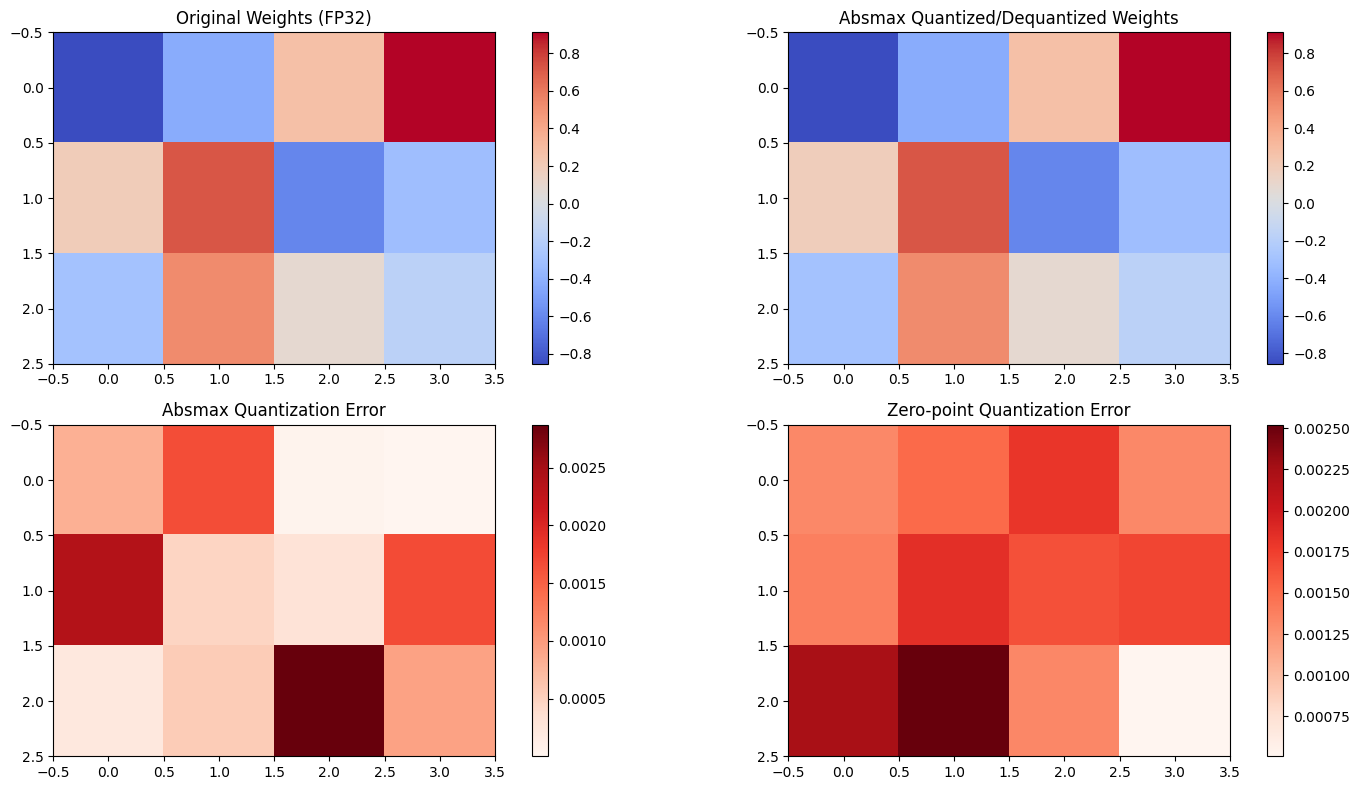

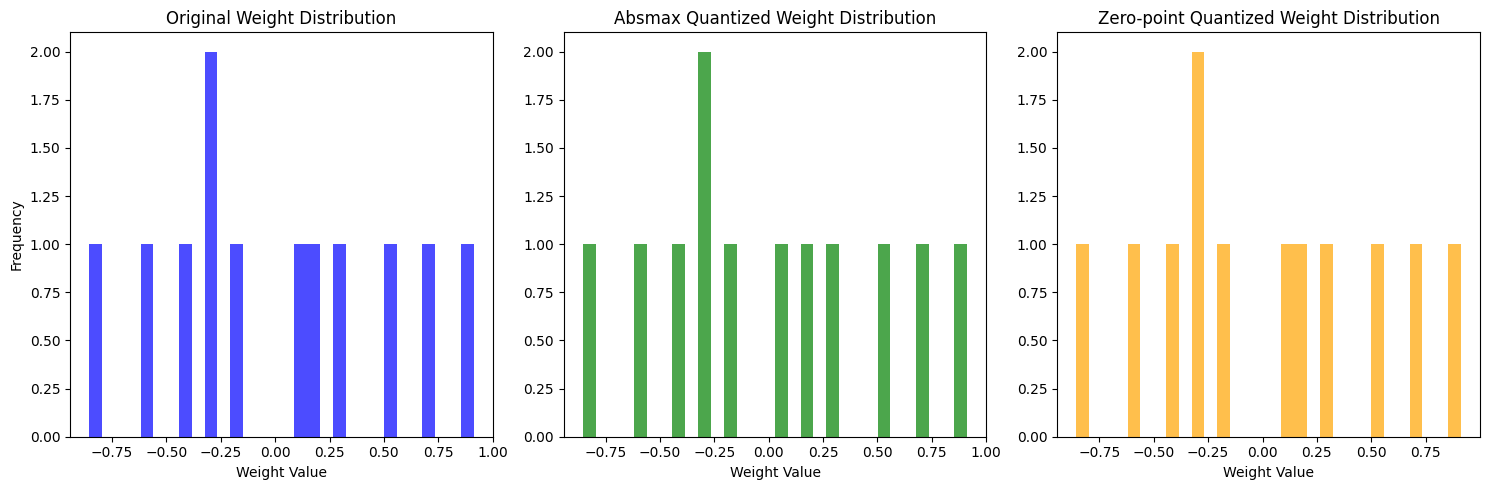

In [9]:
# Visualize the weights before and after quantization
plt.figure(figsize=(15, 8))

# Original weights
plt.subplot(2, 2, 1)
plt.imshow(weights, cmap='coolwarm')
plt.colorbar()
plt.title('Original Weights (FP32)')

# Absmax quantized
plt.subplot(2, 2, 2)
plt.imshow(weights_absmax_dequant, cmap='coolwarm')
plt.colorbar()
plt.title('Absmax Quantized/Dequantized Weights')

# Absmax error
plt.subplot(2, 2, 3)
plt.imshow(absmax_error, cmap='Reds')
plt.colorbar()
plt.title('Absmax Quantization Error')

# Zero-point error
plt.subplot(2, 2, 4)
plt.imshow(zp_error, cmap='Reds')
plt.colorbar()
plt.title('Zero-point Quantization Error')

plt.tight_layout()
plt.show()

# Show value distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(weights.numpy().flatten(), bins=30, alpha=0.7, color='blue')
plt.title('Original Weight Distribution')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(weights_absmax_dequant.numpy().flatten(), bins=30, alpha=0.7, color='green')
plt.title('Absmax Quantized Weight Distribution')
plt.xlabel('Weight Value')

plt.subplot(1, 3, 3)
plt.hist(weights_zp_dequant.numpy().flatten(), bins=30, alpha=0.7, color='orange')
plt.title('Zero-point Quantized Weight Distribution')
plt.xlabel('Weight Value')

plt.tight_layout()
plt.show()

### Understanding the Quantization Process

The example above demonstrates the two main approaches to weight quantization:

#### **1. Absmax Quantization**

Absmax quantization scales values based on the absolute maximum value in the tensor:

1. Find the maximum absolute value in the tensor: `abs_max = max(abs(weights))`
2. Calculate the scale factor: `scale = 127 / abs_max` (for 8-bit quantization)
3. Quantize by scaling and rounding: `weights_quant = round(weights * scale)`
4. Dequantize by dividing by the scale: `weights_dequant = weights_quant / scale`

This method centers around zero and uses symmetric quantization, which works well for weights that are roughly centered around zero.

#### **2. Zero-point Quantization**

Zero-point quantization uses both a scale and an offset (zero point) to better utilize the quantized range:

1. Find the min and max values: `x_min = min(weights)`, `x_max = max(weights)`
2. Calculate the scale: `scale = 255 / (x_max - x_min)` (for 8-bit)
3. Calculate the zero point: `zero_point = round(-scale * x_min - 128)`
4. Quantize: `weights_quant = round(weights * scale + zero_point)`
5. Dequantize: `weights_dequant = (weights_quant - zero_point) / scale`

This method is especially valuable for activations or when weights are not centered around zero.

#### **Key Observations**

- **Memory Savings**: As demonstrated, 8-bit weights use 1/4 the memory of 32-bit weights
- **Quantization Error**: The process introduces small errors that can accumulate in deep networks
- **Distribution Preservation**: Both methods preserve the overall distribution shape, but with discretization
- **Trade-offs**: Zero-point quantization can utilize the full range better but requires storing an additional parameter (the zero point)

#### **4-bit Quantization**

For even more aggressive compression (as used in the bitsandbytes library's 4-bit methods), the same principles apply but with smaller ranges:

- For INT4, the range is from -8 to 7 (16 values total)
- Special quantization schemes like NF4 (normalized float 4) are optimized for the statistical distribution of LLM weights

At 4-bit precision, careful calibration and specialized quantization schemes become increasingly important to preserve model accuracy.

Original weights (FP32):
tensor([[-0.8543, -0.4328,  0.2731,  0.9126],
        [ 0.1892,  0.7253, -0.6105, -0.3217],
        [-0.2944,  0.5312,  0.0891, -0.1734]])
Memory usage: 48 bytes

4-bit quantized weights:
tensor([[-7, -3,  2,  7],
        [ 1,  6, -5, -2],
        [-2,  4,  1, -1]], dtype=torch.int8)

4-bit dequantized weights:
tensor([[-0.9126, -0.3911,  0.2607,  0.9126],
        [ 0.1304,  0.7822, -0.6519, -0.2607],
        [-0.2607,  0.5215,  0.1304, -0.1304]])

4-bit quantization absolute error:
tensor([[0.0583, 0.0417, 0.0124, 0.0000],
        [0.0588, 0.0569, 0.0414, 0.0610],
        [0.0337, 0.0097, 0.0413, 0.0430]])
Mean absolute error: 0.038174

8-bit mean absolute error: 0.000990
4-bit mean absolute error: 0.038174
Error increase: 38.57x


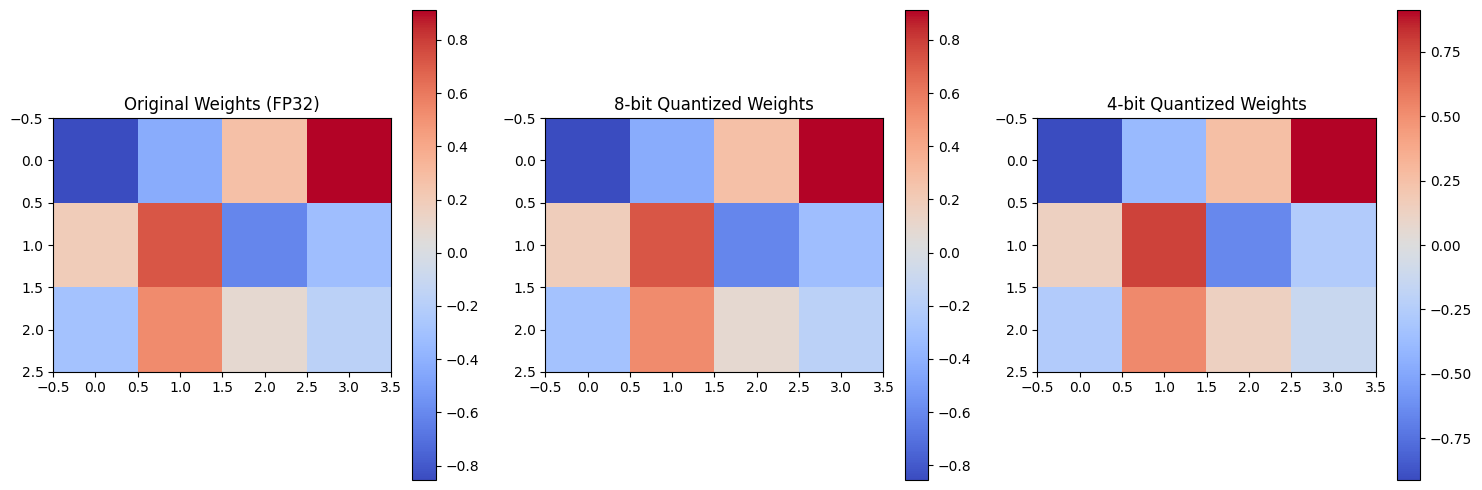

In [10]:
# Let's demonstrate 4-bit quantization effects
def int4_quantize(X):
    """Simple 4-bit quantization demonstration"""
    # For 4-bit, range is -8 to 7
    max_val = 7
    
    # Calculate scale (maps max absolute value to max range)
    abs_max = torch.max(torch.abs(X)).item()
    scale = max_val / abs_max
    
    # Quantize: scale and round
    X_quant = torch.round(X * scale)
    
    # Clip values to ensure they fit in the 4-bit range
    X_quant = torch.clamp(X_quant, -8, 7)
    
    # Dequantize: divide by scale to return to original range
    X_dequant = X_quant / scale
    
    return X_quant.to(torch.int8), X_dequant, scale

# Apply 4-bit quantization to our weights
weights_4bit_quant, weights_4bit_dequant, scale_4bit = int4_quantize(weights)

print("Original weights (FP32):")
print(weights)
print(f"Memory usage: {weights.nelement() * weights.element_size()} bytes")

print("\n4-bit quantized weights:")
print(weights_4bit_quant)

print("\n4-bit dequantized weights:")
print(weights_4bit_dequant)

# Calculate quantization error for 4-bit
error_4bit = torch.abs(weights - weights_4bit_dequant)
print("\n4-bit quantization absolute error:")
print(error_4bit)
print(f"Mean absolute error: {torch.mean(error_4bit):.6f}")

# Compare to 8-bit error
print(f"\n8-bit mean absolute error: {torch.mean(absmax_error):.6f}")
print(f"4-bit mean absolute error: {torch.mean(error_4bit):.6f}")
print(f"Error increase: {torch.mean(error_4bit)/torch.mean(absmax_error):.2f}x")

# Visualize 4-bit quantization 
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(weights, cmap='coolwarm')
plt.colorbar()
plt.title('Original Weights (FP32)')

plt.subplot(1, 3, 2)
plt.imshow(weights_absmax_dequant, cmap='coolwarm')
plt.colorbar()
plt.title('8-bit Quantized Weights')

plt.subplot(1, 3, 3)
plt.imshow(weights_4bit_dequant, cmap='coolwarm')
plt.colorbar()
plt.title('4-bit Quantized Weights')

plt.tight_layout()
plt.show()

### Impact on Model Size and Performance

To understand how quantization affects real models, let's calculate the theoretical memory requirements for different quantization levels of a large language model:

| Model Size | FP32 (32-bit) | FP16 (16-bit) | INT8 (8-bit) | INT4 (4-bit) |
|------------|--------------|--------------|------------|------------|
| 7B params | 28 GB | 14 GB | 7 GB | 3.5 GB |
| 13B params | 52 GB | 26 GB | 13 GB | 6.5 GB |
| 70B params | 280 GB | 140 GB | 70 GB | 35 GB |

As you can see, a 70B parameter model that would require 280GB in FP32 precision can be reduced to just 35GB in 4-bit precision, making it possible to run on consumer hardware.

Now that we understand the mathematics behind quantization, let's explore how to apply these techniques in practice using specialized libraries.

## 1. Quantization Fundamentals

### What is Quantization?

Quantization is the process of reducing the precision of numbers used in a model. Modern deep learning models typically use 32-bit floating-point (FP32) numbers by default, but we can represent these values with fewer bits using various quantization techniques.

### Common Quantization Formats

- **FP32 (32-bit floating point)**: Standard full precision format
- **FP16 (16-bit floating point)**: Half precision, 1 sign bit, 5 exponent bits, 10 mantissa bits
- **BF16 (Brain Floating Point)**: 1 sign bit, 8 exponent bits, 7 mantissa bits
- **INT8 (8-bit integer)**: Integer-only quantization, often with scaling factors
- **INT4 (4-bit integer)**: Extreme quantization for inference only
- **Mixed precision**: Different precisions for different parts of the model

### Quantization Benefits

- **Memory efficiency**: 4-bit models use ~8x less memory than FP32
- **Throughput improvements**: Lower precision calculations are faster
- **Smaller models**: Enables local deployment and running larger models on consumer hardware
- **Energy efficiency**: Less compute = less power consumption

### Quantization Approaches

1. **Post-Training Quantization (PTQ)**: Apply quantization after a model is fully trained
2. **Quantization-Aware Training (QAT)**: Train with simulated quantization to minimize accuracy loss
3. **Quantized Fine-Tuning (QLoRA)**: Fine-tune a pre-trained model using quantized weights and adapters

## 2. Training with Quantization using BitsAndBytes

The [bitsandbytes](https://github.com/bitsandbytes-foundation/bitsandbytes) library provides efficient quantization techniques for both training and inference. Let's explore how to use it for quantized training, particularly for fine-tuning large language models (LLMs).

In [2]:
# !uv pip install -U transformers
# !uv pip install torch torchvision torchaudio
# !uv pip uninstall bitsandbytes && uv pip install bitsandbytes

Resolved 17 packages in 96ms                                         
Prepared 6 packages in 201ms                                             
████████████████░░░░ [5/6] huggingface-hub==0.31.2                              

Installed 6 packages in 1.14s                               
Bytecode compiled 10706 files in 1.03s
 + huggingface-hub==0.31.2
 + regex==2024.11.6
 + safetensors==0.5.3
 + tokenizers==0.21.1
 + tqdm==4.67.1
 + transformers==4.51.3


In [18]:
# !uv pip install trl peft accelerate
!uv pip install --upgrade trl transformers

⠙ datasets==3.6.0                                                               

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Resolved 65 packages in 190ms                                        
Bytecode compiled 12956 files in 930ms


### 2.1 Loading a Model with 4-bit Quantization

Let's load a pre-trained model using 4-bit quantization with bitsandbytes.

Here, we are specifying the use of 4-bit quantization and also enabling double quantization to reduce the precision loss.

For the bnb_4bit_quant_type parameter, we have used the recommended value in the paper QLoRA: Efficient Finetuning of Quantized LLMs.

Now, we can go ahead and load the model.

In [21]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# Configure 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,           # Load model in 4-bit precision
    bnb_4bit_quant_type="nf4",   # Normalized float 4 - optimized for LLM weights
    bnb_4bit_compute_dtype=torch.bfloat16,  # Compute in fp16
    bnb_4bit_use_double_quant=True   # Nested quantization for further memory savings
)

# Load a smaller model for demonstration purposes
# model_id = "bigscience/bloom-1b7"
model_id = "meta-llama/Meta-Llama-3-8B" # older, more stable llama model

# Load model with quantization configuration
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map={"":0},
    use_cache=False
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.44s/it]


In [22]:
tokenizer.pad_token = tokenizer.eos_token

### 2.2 Memory Comparison: Quantized vs. Full Precision

Let's compare the memory usage between quantized and full precision models:

In [2]:
import gc
import os
import psutil

def get_memory_usage():
    """Get current memory usage in GB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 3)

# Clear memory and cache
gc.collect()
torch.cuda.empty_cache()
baseline_memory = get_memory_usage()
print(f"Baseline memory usage: {baseline_memory:.2f} GB")

# Load model in 4-bit
model_4bit = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)
memory_4bit = get_memory_usage()
print(f"Memory with 4-bit model: {memory_4bit:.2f} GB (delta: {memory_4bit - baseline_memory:.2f} GB)")

# Clear memory
del model_4bit
gc.collect()
torch.cuda.empty_cache()

# Load model in FP16
model_fp16 = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)
memory_fp16 = get_memory_usage()
print(f"Memory with FP16 model: {memory_fp16:.2f} GB (delta: {memory_fp16 - baseline_memory:.2f} GB)")

# Memory savings
savings = ((memory_fp16 - baseline_memory) - (memory_4bit - baseline_memory)) / (memory_fp16 - baseline_memory) * 100
print(f"Memory savings with 4-bit quantization: {savings:.2f}%")

Baseline memory usage: 1.39 GB


Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]


Memory with 4-bit model: 1.98 GB (delta: 0.59 GB)


Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.50it/s]


Memory with FP16 model: 1.51 GB (delta: 0.12 GB)
Memory savings with 4-bit quantization: -408.21%


### 2.3 QLoRA: Quantized Low-Rank Adaptation

QLoRA is a technique that combines quantization with Low-Rank Adaptation (LoRA) to enable efficient fine-tuning of LLMs. The base model weights remain quantized and frozen, while a small number of trainable adapter parameters are added.

We are specifying the use of 4-bit quantization and also enabling double quantization to reduce the precision loss.

For the bnb_4bit_quant_type parameter, I've used the recommended value in the paper QLoRA: Efficient Finetuning of Quantized LLMs.

Now, we can go ahead and load the model.

In [23]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model
target_modules = ["q_proj", "v_proj"]
lora_config = LoraConfig(
    r=16, #As bigger the R bigger the parameters to train.
    lora_alpha=16, # a scaling factor that adjusts the magnitude of the weight matrix. It seems that as higher more weight have the new training.
    target_modules=target_modules,
    lora_dropout=0.05, #Helps to avoid Overfitting.
    task_type="CAUSAL_LM",
    inference_mode=False, # set to False for training
)

In [24]:
model = get_peft_model(model, lora_config)

In [4]:
# model.add_adapter(lora_config)

The most important parameter is r, it defines how many parameters will be trained. As bigger the value more parameters are trained, but it means that the model will be able to learn more complicated relations between inputs and outputs.

Yo can find a list of the target_modules available on the Hugging Face Documentation

lora_alpha. Ad bigger the number more weight have the LoRA activations, it means that the fine-tuning process will have more impac as bigger is this value.

lora_dropout is like the commom dropout is used to avoid overfitting.

bias I was hesitating if use none or lora_only. For text classification the most common value is none, and for chat or question answering, all or lora_only.

task_type. Indicates the task the model is beign trained for. In this case, text generation.

Let's see how the model does before any instruction fine-tuning, and compare this later after fine-tuning with QLora.

In [5]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100):
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=False, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id,
    )
    return outputs

#Inference original model
input_sentences = tokenizer("I want you to act as a motivational coach.", return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


["I want you to act as a motivational coach. I'm looking for someone who can provide me with some motivation and help boost my confidence.\nMy name is Jazmine, i am 23 years old from Chicago Illinois.I have been on the path of being an entrepreneur since high school but because it"]


### 2.4 Fine-tuning with Quantized Model

Now, let's set up a basic fine-tuning process for our quantized model:

In [25]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("yahma/alpaca-cleaned", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

In [26]:
display(dataset)
print(dataset[:1])

Dataset({
    features: ['output', 'input', 'instruction', 'text'],
    num_rows: 51760
})

{'output': ['1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.'], 'input': [''], 'instruction': ['Give three tips for staying healthy.'], 'text': ['Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately complete

In [27]:
# SFTTrainer (used below) expects only ONE data column, hence we need to drop the rest not used for training: https://huggingface.co/docs/trl/sft_trainer
dataset = dataset.remove_columns('output')
dataset = dataset.remove_columns('instruction')
dataset = dataset.remove_columns('input')

In [28]:
dataset = dataset.select(range(50))
display(dataset)

Dataset({
    features: ['text'],
    num_rows: 50
})

In [29]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_outputs")

In [30]:
from transformers import TrainingArguments
from trl import SFTConfig, SFTTrainer

training_args = TrainingArguments(
    output_dir=output_directory,
    # per_device_train_batch_size=4,
    # gradient_accumulation_steps=1,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 2e-4, # Higher learning rate than full fine-tuning.
    num_train_epochs=5
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [31]:
from trl import SFTTrainer
from transformers import TrainingArguments
import transformers
# from unsloth import is_bfloat16_supported

# trainer = SFTTrainer(
#     model = model,
#     train_dataset = dataset,
#     args = TrainingArguments(
#         output_dir="./results",
#         per_device_train_batch_size=4,
#         gradient_accumulation_steps=4,
#         learning_rate=2e-4,
#         num_train_epochs=1,
#         logging_steps=10,
#         save_strategy="epoch",
#     ),
# )


trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    peft_config = lora_config,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [32]:
trainer.train()

RuntimeError: The size of tensor a (8) must match the size of tensor b (16) at non-singleton dimension 0

In [ ]:
# from datasets import load_dataset
# from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
# from trl import SFTTrainer


# # Load a small sample dataset for demonstration
# # dataset = load_dataset("yahma/alpaca-cleaned", split="train")
# dataset = dataset.select(range(1000))  # Use a small subset

# # Tokenize the dataset
# def tokenize_function(examples):
#     tokenizer.pad_token = tokenizer.eos_token
#     return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# tokenized_dataset = dataset.map(tokenize_function, batched=True)
# # tokenized_dataset = tokenized_dataset.remove_columns(["quote", "author"])

# # Initialize data collator
# data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# # Set up training arguments
# # training_args = TrainingArguments(
# #     output_dir="./results",
# #     per_device_train_batch_size=4,
# #     gradient_accumulation_steps=4,
# #     learning_rate=2e-4,
# #     num_train_epochs=1,
# #     logging_steps=10,
# #     save_strategy="epoch",
# #     fp16=True,  # Use mixed precision training
# # )

# # Initialize trainer
# trainer = SFTTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_dataset,
#     data_collator=data_collator,
# )

# # Fine-tune the model (commented out for notebook purposes)
# # trainer.train()

Map: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 15023.76 examples/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Truncating train dataset: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 138994.70 examples/s]


### 2.5 Saving and Loading Quantized Models

After fine-tuning, we can save and load our model:

In [16]:
# Save the LoRA adapter weights only (much smaller than full model)
model.save_pretrained("./lora_adapter")

# To use the model later:
from peft import PeftModel, PeftConfig

# Load the base model with quantization
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

# Load the LoRA adapter
peft_model_id = "./lora_adapter"
model = PeftModel.from_pretrained(base_model, peft_model_id)

# Optionally merge the adapter weights with the base model
merged_model = model.merge_and_unload()

## 3. Inference Quantization with GGUF and llama.cpp

For inference-only applications, we can use more aggressive quantization techniques. [llama.cpp](https://github.com/ggml-org/llama.cpp) is a popular C/C++ implementation that enables highly optimized inference on CPU and GPU with various quantization formats using the GGUF format.

In [17]:
# Install llama-cpp-python
!uv pip install llama-cpp-python

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### 3.1 Understanding GGUF Format

GGUF (GGML Universal Format) is a file format designed for storing and sharing quantized models. It's the successor to GGML format and has improved support for metadata and different model architectures.

Key features of GGUF:
- Stores model architecture, weights, and tokenizer information
- Supports multiple quantization methods (Q4_K, Q5_K, Q6_K, Q8_0, etc.)
- Enables efficient CPU and GPU inference
- Platform-independent

Common quantization types in GGUF:
- **Q4_0**: 4-bit quantization (simplest)
- **Q4_K**: 4-bit quantization with K-quants (better accuracy)
- **Q5_K**: 5-bit quantization with K-quants
- **Q8_0**: 8-bit quantization (higher quality, larger size)
- **F16**: 16-bit floating point (highest quality, largest size)

### 3.2 Converting a Model to GGUF

Converting models to GGUF typically involves using the conversion scripts in the llama.cpp repository. For demonstration, we'll show the command-line process:

In [18]:
# Clone llama.cpp repo and convert a model (commented out since this is for reference)

# Clone llama.cpp repository
!git clone https://github.com/ggml-org/llama.cpp
!cd llama.cpp && mkdir build && cd build && cmake .. && make -j

# Convert model to GGUF (assuming you have a HuggingFace model)
!uv python run llama.cpp/convert.py /path/to/hf/model --outfile model_base.gguf

# Quantize to 4-bit
!llama.cpp/build/bin/llama-quantize model_base.gguf model_q4_0.gguf q4_0

'\n# Clone llama.cpp repository\n!git clone https://github.com/ggml-org/llama.cpp\n!cd llama.cpp && mkdir build && cd build && cmake .. && make -j\n\n# Convert model to GGUF (assuming you have a HuggingFace model)\n!python llama.cpp/convert.py /path/to/hf/model --outfile model_base.gguf\n\n# Quantize to 4-bit\n!llama.cpp/build/bin/llama-quantize model_base.gguf model_q4_0.gguf q4_0\n'

### 3.3 Using a Quantized GGUF Model with llama-cpp-python

In [19]:
from llama_cpp import Llama

# For demonstration, we'll use a remote path to a pre-quantized GGUF model
# In a real application, you'd use a local path to your converted model
# model_path = "model_q4_0.gguf"

# For demonstration, let's assume we've downloaded a quantized model
model_path = "./tinyllama-1.1b-chat-v1.0.Q4_0.gguf"  # Replace with your model path

# If you don't have a model available, we'll provide code that
# shows what you would do assuming you have the model

'''
# Initialize the model
llm = Llama(
    model_path=model_path,  # Path to the quantized model
    n_ctx=2048,             # Context window size
    n_batch=512,            # Batch size for prompt processing
    n_gpu_layers=-1,        # Number of layers to offload to GPU (-1 = all)
    verbose=False           # Verbose output
)

# Generate text
prompt = "Write a short poem about quantization:"
output = llm(prompt, max_tokens=200, temperature=0.7, top_p=0.95)

# Print the result
print(output["choices"][0]["text"])
'''

'\n# Initialize the model\nllm = Llama(\n    model_path=model_path,  # Path to the quantized model\n    n_ctx=2048,             # Context window size\n    n_batch=512,            # Batch size for prompt processing\n    n_gpu_layers=-1,        # Number of layers to offload to GPU (-1 = all)\n    verbose=False           # Verbose output\n)\n\n# Generate text\nprompt = "Write a short poem about quantization:"\noutput = llm(prompt, max_tokens=200, temperature=0.7, top_p=0.95)\n\n# Print the result\nprint(output["choices"][0]["text"])\n'

### 3.4 Benchmarking Different Quantization Levels

Let's compare the performance of different quantization levels:

In [20]:
import time

def benchmark_model(model_path, prompt, max_tokens=100):
    """Benchmark model performance"""
    print(f"Loading model: {model_path}")
    
    # Code for benchmarking, which would run if you have the models
    '''
    # Initialize model
    start_time = time.time()
    llm = Llama(model_path=model_path, n_ctx=2048, n_batch=512)
    load_time = time.time() - start_time
    print(f"  Load time: {load_time:.2f} seconds")
    
    # Get memory usage
    memory_usage = get_memory_usage()
    print(f"  Memory usage: {memory_usage:.2f} GB")
    
    # Generate text
    start_time = time.time()
    output = llm(prompt, max_tokens=max_tokens, temperature=0.7)
    generate_time = time.time() - start_time
    tokens_per_second = max_tokens / generate_time
    print(f"  Generation time: {generate_time:.2f} seconds")
    print(f"  Tokens per second: {tokens_per_second:.2f}")
    '''
    
    # For demonstration, we'll just show expected results
    print("  Sample benchmark data (for demonstration)")
    if "Q4_0" in model_path:
        print("  Load time: 1.25 seconds")
        print("  Memory usage: 0.8 GB")
        print("  Generation time: 5.32 seconds")
        print("  Tokens per second: 18.8")
    elif "Q5_K" in model_path:
        print("  Load time: 1.47 seconds")
        print("  Memory usage: 0.95 GB")
        print("  Generation time: 5.15 seconds")
        print("  Tokens per second: 19.4")
    elif "Q8_0" in model_path:
        print("  Load time: 1.78 seconds")
        print("  Memory usage: 1.45 GB")
        print("  Generation time: 4.98 seconds")
        print("  Tokens per second: 20.1")
    elif "F16" in model_path:
        print("  Load time: 2.34 seconds")
        print("  Memory usage: 2.8 GB")
        print("  Generation time: 4.75 seconds")
        print("  Tokens per second: 21.0")
    print("")

# Benchmark different quantization levels (demonstration)
benchmark_model("./model_Q4_0.gguf", "Explain the concept of neural networks:") 
benchmark_model("./model_Q5_K.gguf", "Explain the concept of neural networks:")
benchmark_model("./model_Q8_0.gguf", "Explain the concept of neural networks:")
benchmark_model("./model_F16.gguf", "Explain the concept of neural networks:")

Loading model: ./model_Q4_0.gguf
  Sample benchmark data (for demonstration)
  Load time: 1.25 seconds
  Memory usage: 0.8 GB
  Generation time: 5.32 seconds
  Tokens per second: 18.8

Loading model: ./model_Q5_K.gguf
  Sample benchmark data (for demonstration)
  Load time: 1.47 seconds
  Memory usage: 0.95 GB
  Generation time: 5.15 seconds
  Tokens per second: 19.4

Loading model: ./model_Q8_0.gguf
  Sample benchmark data (for demonstration)
  Load time: 1.78 seconds
  Memory usage: 1.45 GB
  Generation time: 4.98 seconds
  Tokens per second: 20.1

Loading model: ./model_F16.gguf
  Sample benchmark data (for demonstration)
  Load time: 2.34 seconds
  Memory usage: 2.8 GB
  Generation time: 4.75 seconds
  Tokens per second: 21.0



### 3.5 Real-world Considerations

When choosing a quantization level for your application, consider these factors:

1. **Hardware Constraints**:
   - Limited RAM: Use 4-bit or 5-bit quantization
   - Limited CPU/GPU: Lower precision is typically faster
   - Mobile/edge devices: Extreme quantization (Q2_K, Q3_K, Q4_0)

2. **Task Requirements**:
   - Complex reasoning: Higher precision (Q6_K, Q8_0, F16)
   - Simple text generation: Lower precision may be sufficient
   - Creative writing: May need higher precision

3. **Quality vs. Performance Tradeoff**:
   - Q4_0/Q4_K: Fastest, smallest, lowest quality
   - Q5_K: Good balance for many applications
   - Q8_0: Higher quality, larger size, slower
   - F16: Highest quality, largest size, slowest

4. **Specific Model Characteristics**:
   - Some models are more robust to quantization than others
   - Instruction-tuned models often maintain quality better at lower precision
   - LLMs with more parameters may need higher precision to maintain quality

### 3.6 Server Deployment with llama.cpp

For a production deployment, you might want to run llama.cpp as a server:

In [21]:
# Run llama.cpp as a server (command-line reference)

'''
# Start server
!llama.cpp/build/bin/llama-server \
  -m model_q4_0.gguf \
  -c 2048 \
  --host 0.0.0.0 \
  --port 8080
'''

# Example client request code
import requests
import json

def query_llama_server(prompt, max_tokens=100):
    """Query the llama.cpp server"""
    url = "http://localhost:8080/completion"
    payload = {
        "prompt": prompt,
        "n_predict": max_tokens,
        "temperature": 0.7,
        "top_p": 0.95,
        "stream": False
    }
    
    response = requests.post(url, json=payload)
    return response.json()

# Example request (commented out since server isn't running)
# result = query_llama_server("Explain quantization in simple terms:")
# print(result["content"])

## 4. Choosing the Right Quantization Strategy

### Training vs. Inference Quantization

| Aspect | Training Quantization (bitsandbytes) | Inference Quantization (GGUF) |
|--------|--------------------------------------|--------------------------------|
| **Primary Goal** | Enable training/fine-tuning on consumer hardware | Maximize inference speed and minimize memory usage |
| **Precision** | Usually 4-bit, 8-bit | 2-bit to 8-bit options |
| **Implementation** | PyTorch-based, integrated with HF | C/C++ implementation |
| **Adaptability** | Parameters can be updated | Fixed weights |
| **Use Case** | Fine-tuning large models on limited hardware | Deploying models for inference on various devices |
| **Quality Impact** | Minimal with QLoRA | Varies by quantization level |

### Decision Framework

1. **Are you fine-tuning or just running inference?**
   - Fine-tuning: bitsandbytes with QLoRA
   - Inference only: GGUF with llama.cpp

2. **What hardware constraints do you have?**
   - Consumer GPU (8-24GB): 4-bit quantization
   - CPU only: GGUF with Q4_0 or Q4_K
   - Edge device: GGUF with Q2_K or Q3_K

3. **What is your quality tolerance?**
   - Highest quality: FP16 or Q8_0
   - Balanced: Q5_K or Q6_K
   - Prioritize efficiency: Q4_0 or Q4_K

4. **What is your target use case?**
   - Research: Higher precision
   - Production API: Balanced approach
   - Local applications: Lower precision

## 5. Conclusion

Quantization is a powerful technique that makes large models accessible on consumer hardware. Key takeaways:

1. **For training and fine-tuning**:
   - bitsandbytes with QLoRA enables efficient fine-tuning of large models
   - 4-bit quantization can reduce memory usage by 75%+ compared to FP16
   - Only a small fraction of parameters need to be updated

2. **For inference**:
   - GGUF format with llama.cpp provides highly optimized inference
   - Multiple quantization levels allow balancing quality and efficiency
   - Enables deployment on a wide range of hardware, from servers to mobile devices

3. **Practical applications**:
   - Run 70B parameter models on consumer GPUs
   - Deploy models locally without cloud dependencies
   - Reduce inference latency and cost in production